In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [3]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc= nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            self._block(features_d, features_d* 2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias= False,
            ),
            nn.InstanceNorm2d(out_channels, affine= True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net= nn.Sequential(
            self._block(channels_noise, features_g* 16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size= 4, stride= 2, padding=1
            ),
            nn.Tanh(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias= False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
def test():
    N, in_channels, H, W= 8, 3, 64, 64
    noise_dim= 100
    x= torch.randn((N, in_channels, H, W))
    disc= Discriminator(in_channels, 8)
    assert disc(x).shape== (N, 1, 1, 1), "Discriminator test Failed"
    gen= Generator(noise_dim, in_channels, 8)
    z= torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape== (N, in_channels, H, W),"Generator test Failed"
    print("Success")
test()

Success


In [8]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [9]:
dataset = datasets.MNIST(root='dataset', train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32859992.54it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1024437.98it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9445603.47it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3273286.73it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [10]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [11]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [12]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

 11%|█         | 101/938 [00:16<02:24,  5.79it/s]

Epoch [0/100] Batch 100/938                   Loss D: -111.6863, loss G: 60.8978


 22%|██▏       | 202/938 [00:31<01:51,  6.58it/s]

Epoch [0/100] Batch 200/938                   Loss D: -129.1614, loss G: 93.3522


 32%|███▏      | 302/938 [00:46<01:38,  6.49it/s]

Epoch [0/100] Batch 300/938                   Loss D: -125.8555, loss G: 107.3832


 43%|████▎     | 402/938 [01:02<01:23,  6.39it/s]

Epoch [0/100] Batch 400/938                   Loss D: -117.8023, loss G: 109.5497


 54%|█████▎    | 502/938 [01:17<01:08,  6.40it/s]

Epoch [0/100] Batch 500/938                   Loss D: -106.2054, loss G: 111.2203


 64%|██████▍   | 602/938 [01:33<00:53,  6.30it/s]

Epoch [0/100] Batch 600/938                   Loss D: -92.6043, loss G: 93.2038


 75%|███████▍  | 702/938 [01:48<00:36,  6.38it/s]

Epoch [0/100] Batch 700/938                   Loss D: -81.4346, loss G: 89.8585


 86%|████████▌ | 802/938 [02:03<00:21,  6.43it/s]

Epoch [0/100] Batch 800/938                   Loss D: -68.1023, loss G: 93.1516


 96%|█████████▌| 902/938 [02:19<00:05,  6.44it/s]

Epoch [0/100] Batch 900/938                   Loss D: -57.9541, loss G: 83.8276


 11%|█         | 102/938 [00:15<02:11,  6.34it/s]

Epoch [1/100] Batch 100/938                   Loss D: -42.6401, loss G: 83.8447


 22%|██▏       | 202/938 [00:30<01:54,  6.41it/s]

Epoch [1/100] Batch 200/938                   Loss D: -35.4421, loss G: 78.9041


 32%|███▏      | 302/938 [00:46<01:42,  6.23it/s]

Epoch [1/100] Batch 300/938                   Loss D: -29.6362, loss G: 75.0110


 43%|████▎     | 402/938 [01:01<01:23,  6.39it/s]

Epoch [1/100] Batch 400/938                   Loss D: -23.1057, loss G: 78.3189


 54%|█████▎    | 502/938 [01:17<01:11,  6.08it/s]

Epoch [1/100] Batch 500/938                   Loss D: -20.8231, loss G: 70.9198


 64%|██████▍   | 602/938 [01:32<00:52,  6.37it/s]

Epoch [1/100] Batch 600/938                   Loss D: -15.7293, loss G: 80.2202


 75%|███████▍  | 702/938 [01:47<00:37,  6.29it/s]

Epoch [1/100] Batch 700/938                   Loss D: -13.5517, loss G: 72.8172


 86%|████████▌ | 802/938 [02:03<00:21,  6.40it/s]

Epoch [1/100] Batch 800/938                   Loss D: -11.5822, loss G: 70.4201


 96%|█████████▌| 902/938 [02:18<00:05,  6.32it/s]

Epoch [1/100] Batch 900/938                   Loss D: -10.4035, loss G: 68.5965


 11%|█         | 102/938 [00:15<02:10,  6.40it/s]

Epoch [2/100] Batch 100/938                   Loss D: -10.8853, loss G: 74.5765


 22%|██▏       | 202/938 [00:30<01:54,  6.42it/s]

Epoch [2/100] Batch 200/938                   Loss D: -9.2722, loss G: 70.8156


 32%|███▏      | 302/938 [00:46<01:39,  6.37it/s]

Epoch [2/100] Batch 300/938                   Loss D: -7.4712, loss G: 69.3713


 43%|████▎     | 402/938 [01:01<01:24,  6.38it/s]

Epoch [2/100] Batch 400/938                   Loss D: -10.9720, loss G: 76.6584


 54%|█████▎    | 502/938 [01:16<01:08,  6.39it/s]

Epoch [2/100] Batch 500/938                   Loss D: -9.6590, loss G: 75.0189


 64%|██████▍   | 602/938 [01:32<00:52,  6.39it/s]

Epoch [2/100] Batch 600/938                   Loss D: -10.6808, loss G: 68.6420


 75%|███████▍  | 702/938 [01:47<00:36,  6.42it/s]

Epoch [2/100] Batch 700/938                   Loss D: -9.3101, loss G: 81.8666


 86%|████████▌ | 802/938 [02:03<00:21,  6.43it/s]

Epoch [2/100] Batch 800/938                   Loss D: -11.3840, loss G: 78.3720


 96%|█████████▌| 902/938 [02:18<00:05,  6.20it/s]

Epoch [2/100] Batch 900/938                   Loss D: -8.3100, loss G: 71.9144


 11%|█         | 102/938 [00:15<02:12,  6.31it/s]

Epoch [3/100] Batch 100/938                   Loss D: -9.2365, loss G: 70.2363


 22%|██▏       | 202/938 [00:31<01:57,  6.25it/s]

Epoch [3/100] Batch 200/938                   Loss D: -9.4466, loss G: 80.5291


 32%|███▏      | 302/938 [00:47<01:39,  6.36it/s]

Epoch [3/100] Batch 300/938                   Loss D: -8.2196, loss G: 74.1251


 43%|████▎     | 402/938 [01:02<01:27,  6.11it/s]

Epoch [3/100] Batch 400/938                   Loss D: -9.0144, loss G: 74.5737


 54%|█████▎    | 502/938 [01:18<01:09,  6.28it/s]

Epoch [3/100] Batch 500/938                   Loss D: -7.7519, loss G: 71.4487


 64%|██████▍   | 602/938 [01:34<00:53,  6.28it/s]

Epoch [3/100] Batch 600/938                   Loss D: -10.4960, loss G: 77.5489


 75%|███████▍  | 702/938 [01:49<00:37,  6.23it/s]

Epoch [3/100] Batch 700/938                   Loss D: -7.7210, loss G: 78.4857


 86%|████████▌ | 802/938 [02:05<00:21,  6.28it/s]

Epoch [3/100] Batch 800/938                   Loss D: -7.4284, loss G: 72.0817


 96%|█████████▌| 902/938 [02:21<00:05,  6.23it/s]

Epoch [3/100] Batch 900/938                   Loss D: -9.2869, loss G: 77.5153


 11%|█         | 102/938 [00:15<02:20,  5.96it/s]

Epoch [4/100] Batch 100/938                   Loss D: -7.7750, loss G: 74.9848


 22%|██▏       | 202/938 [00:31<01:57,  6.26it/s]

Epoch [4/100] Batch 200/938                   Loss D: -7.7441, loss G: 79.2099


 32%|███▏      | 302/938 [00:47<01:42,  6.20it/s]

Epoch [4/100] Batch 300/938                   Loss D: -7.9488, loss G: 77.5068


 43%|████▎     | 402/938 [01:02<01:26,  6.20it/s]

Epoch [4/100] Batch 400/938                   Loss D: -6.6331, loss G: 77.0781


 54%|█████▎    | 502/938 [01:18<01:10,  6.18it/s]

Epoch [4/100] Batch 500/938                   Loss D: -6.4117, loss G: 74.4194


 64%|██████▍   | 602/938 [01:34<00:53,  6.31it/s]

Epoch [4/100] Batch 600/938                   Loss D: -7.0673, loss G: 82.1236


 75%|███████▍  | 702/938 [01:49<00:38,  6.07it/s]

Epoch [4/100] Batch 700/938                   Loss D: -7.8748, loss G: 80.4330


 86%|████████▌ | 802/938 [02:05<00:21,  6.28it/s]

Epoch [4/100] Batch 800/938                   Loss D: -5.5569, loss G: 80.1035


 96%|█████████▌| 902/938 [02:20<00:05,  6.01it/s]

Epoch [4/100] Batch 900/938                   Loss D: -7.8946, loss G: 81.0507


  4%|▍         | 41/938 [00:06<02:19,  6.44it/s]


KeyboardInterrupt: 

In [13]:
def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [14]:
def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [20]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(images, title):
    # Create a grid from batch of images
    grid = vutils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()


In [21]:
def display_real_and_fake_images(generator, dataloader, device, num_images=32, z_dim=128):
    # Get a batch of real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images].to(device)

    # Generate fake images
    fixed_noise = torch.randn(num_images, z_dim, 1, 1).to(device)
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    
    generator.train()

    # Display real images
    show_images(real_images, title="Real Images")

    # Display generated images
    show_images(fake_images, title="Generated Images")


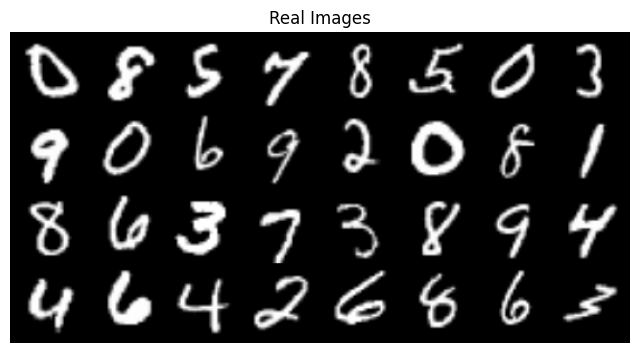

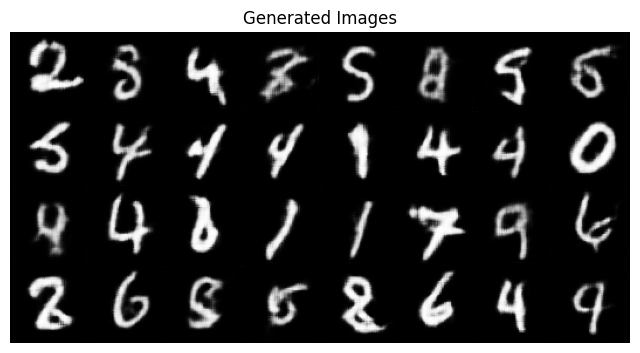

In [22]:
display_real_and_fake_images(gen, loader, device, num_images=32, z_dim=Z_DIM)